In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

%load_ext lab_black

In [16]:
def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    per_metric_dfs = []
    for genre in genres:
        per_genre_dfs = []
        for metric in metric_names:
            df = pd.DataFrame(np.array(results[metric][genre]), columns=["value"])
            df["metric"] = metric
            df["model"] = genre
            per_genre_dfs.append(df)
        per_metric_dfs.append(pd.concat(per_genre_dfs, axis=0))

    return pd.concat(per_metric_dfs, axis=0)[["model", "metric", "value"]]

In [17]:
results_fpath = "../results/bodhidharma"
nano_df = []
macro_df = []
tonnetz_df = []

# Load the results
for model_name in os.listdir(results_fpath):
    [fname] = os.listdir(os.path.join(results_fpath, model_name))
    fpath = os.path.join(results_fpath, model_name, fname)

    with open(fpath, "r") as f:
        results = json.load(f)

    # Create dataframes
    chromas = build_df(results, ["chroma_similarities"])
    tonnetz_distances = build_df(results, ["tonnetz_distances"])
    style_macro = build_df(results, ["macro_time_pitch_diff", "macro_onset_duration"])
    style_per_song = build_df(
        results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
    )

    nano_metrics = pd.concat([chromas, style_per_song], axis=0)
    nano_metrics["model_name"] = model_name
    tonnetz_distances["model_name"] = model_name
    style_macro["model_name"] = model_name
    nano_df.append(nano_metrics)
    tonnetz_df.append(tonnetz_distances)
    macro_df.append(style_macro)

nano_df = pd.concat(nano_df, axis=0)
tonnetz_df = pd.concat(tonnetz_df, axis=0)
macro_df = pd.concat(macro_df, axis=0)

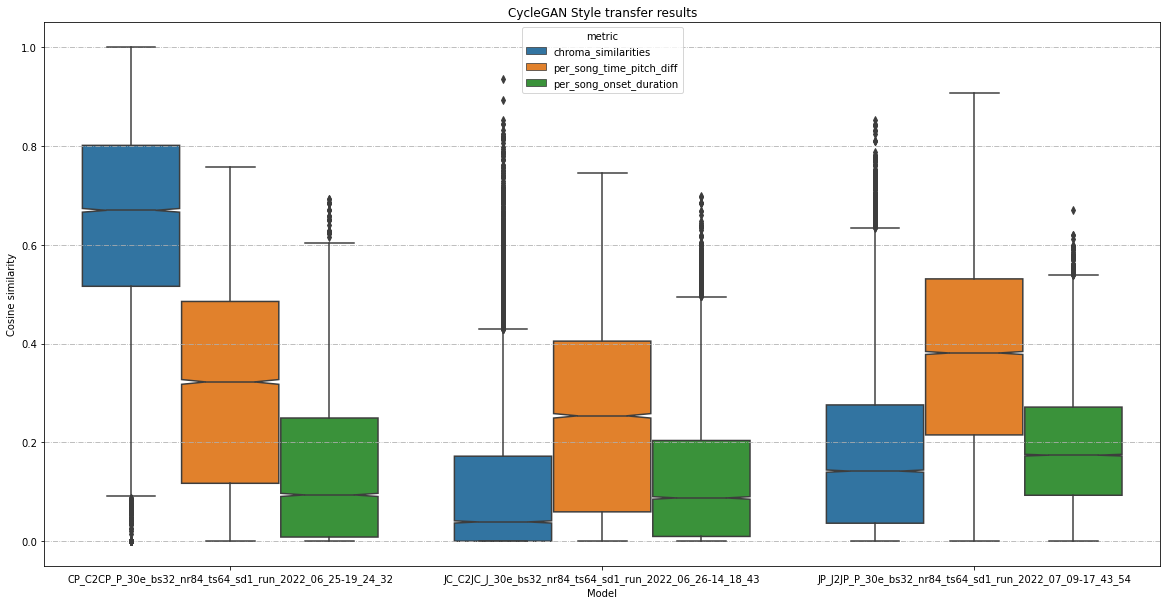

In [18]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.boxplot(
    x="model_name", y="value", hue="metric", data=nano_df, ax=ax, notch=True
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN Style transfer results")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")


plt.show()

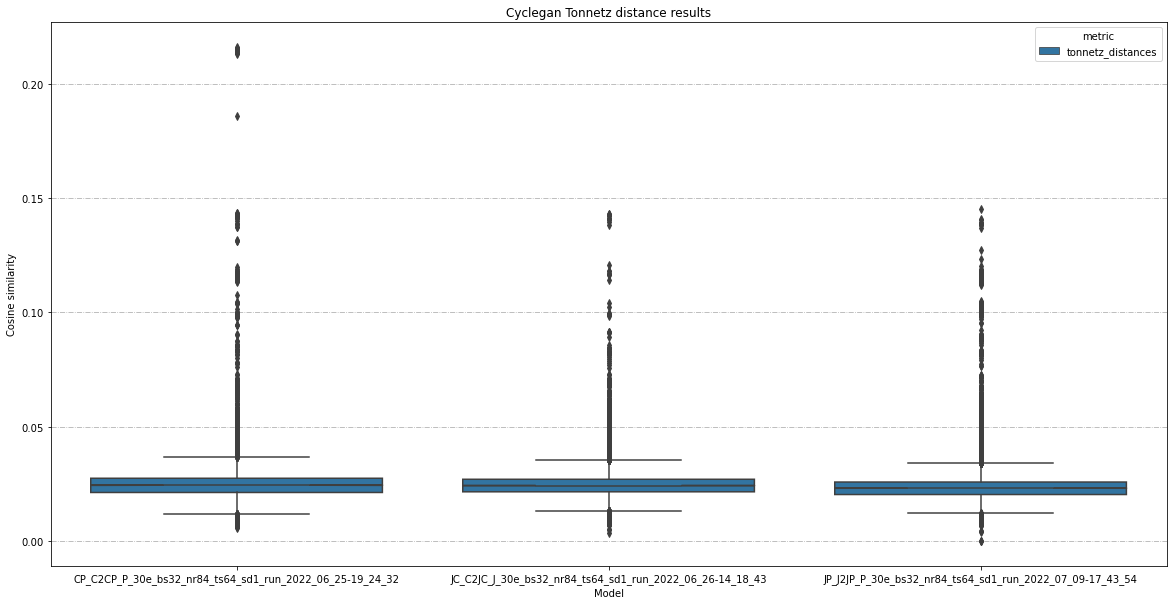

In [19]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.boxplot(
    x="model_name", y="value", hue="metric", data=tonnetz_df, ax=ax, notch=True
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("Cyclegan Tonnetz distance results")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")

plt.show()

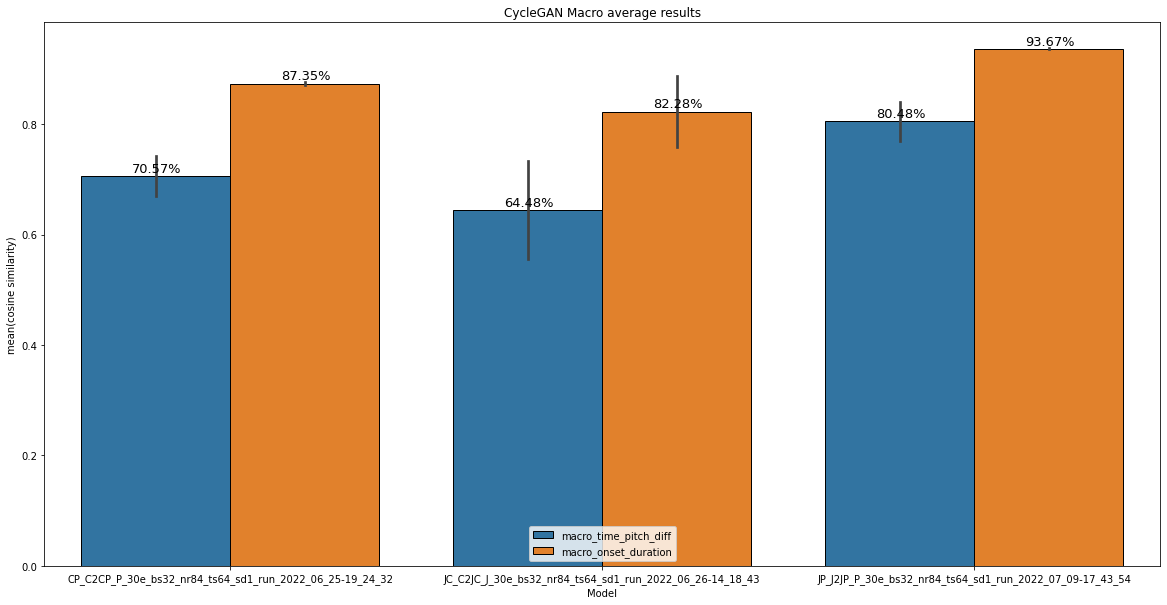

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x="model_name", y="value", hue="metric", data=macro_df, ec="k", lw=1,)
autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax.legend(loc="lower center")

ax.set_title("CycleGAN Macro average results")
ax.set_xlabel("Model")
ax.set_ylabel("mean(cosine similarity)")

plt.show()